# **INITIAL SETUP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/fz-fyp-new/T1.csv', parse_dates=['Date/Time'])



In [ ]:
print(df.head())
print(df.info())
print("Missing values per column:")
print(df.isnull().sum())

          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV A

# **Data preprocessing**

In [ ]:
df.sort_values(by='Date/Time', inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.interpolate(method='linear', inplace=True)

<ipython-input-39-94aaac17319d>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [ ]:
rated_capacity = 3600
df.loc[df['LV ActivePower (kW)'] > rated_capacity, 'LV ActivePower (kW)'] = rated_capacity

In [ ]:
cut_in_speed = 3
df.loc[df['Wind Speed (m/s)'] < cut_in_speed, 'LV ActivePower (kW)'] = 0

In [ ]:
print("Data Preprocessing Completed:")
print(df.head())
print(df.info())
print("Missing values per column:")
print(df.isnull().sum())


Data Preprocessing Completed:
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      505

# **Feature engineering**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')

In [ ]:
# 2. Extract Time Features
df['Hour'] = df['Date/Time'].dt.hour        # Extract hour (0-23)
df['Month'] = df['Date/Time'].dt.month       # Extract month (1-12)

In [ ]:
#Create Cyclical Features
# For Hour (24-hour cycle):
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# For Month (12-month cycle):
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# For Wind Direction (0-360° cycle):
df['wd_sin'] = np.sin(np.radians(df['Wind Direction (°)']))
df['wd_cos'] = np.cos(np.radians(df['Wind Direction (°)']))


In [ ]:
#Create Lag Features (assuming data is at 10-min intervals)
df['Power_lag1'] = df['LV ActivePower (kW)'].shift(1)
df['Power_lag2'] = df['LV ActivePower (kW)'].shift(2)
df['Power_lag3'] = df['LV ActivePower (kW)'].shift(3)

df['WindSpeed_lag1'] = df['Wind Speed (m/s)'].shift(1)
df['WindSpeed_lag2'] = df['Wind Speed (m/s)'].shift(2)
df['WindSpeed_lag3'] = df['Wind Speed (m/s)'].shift(3)

In [ ]:
#Create Rolling Averages (using a window of 3 to capture 30-min trends)
df['WindSpeed_rolling_mean_3'] = df['Wind Speed (m/s)'].rolling(window=3).mean()
df['Power_rolling_mean_3'] = df['LV ActivePower (kW)'].rolling(window=3).mean()


In [ ]:
#Create the 30-Minute Ahead Target Variable
df['Power_Tplus30'] = df['LV ActivePower (kW)'].shift(-3)

In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Define feature columns
feature_cols = [
    'Wind Speed (m/s)', 'wd_sin', 'wd_cos', 'Hour_sin', 'Hour_cos',
    'Month_sin', 'Month_cos', 'Power_lag1', 'Power_lag2', 'Power_lag3',
    'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
    'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3'
]

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [ ]:
print("Feature Engineering Completed:")
print(df.head())
print("Data types:")
print(df.dtypes)


Feature Engineering Completed:
            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:30:00           419.645905          0.224537   
1 2018-01-01 00:40:00           380.650696          0.221294   
2 2018-01-01 00:50:00           402.391998          0.222330   
3 2018-01-01 01:00:00           447.605713          0.229826   
4 2018-01-01 01:10:00           387.242188          0.210507   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  Hour  Month  Hour_sin  \
0                     516.127569          271.258087     0      1   0.50000   
1                     491.702972          265.674286     0      1   0.50000   
2                     499.436385          264.578613     0      1   0.50000   
3                     557.372363          266.163605     1      1   0.62941   
4                     414.898179          257.949493     1      1   0.62941   

   Hour_cos  Month_sin  ...    wd_cos  Power_lag1  Power_lag2  Power_lag3  \
0  1.000000       0.75  ...  0.5

# **Model training & hyperparameteer tuning**

In [ ]:
print("Total data samples:", len(df))

Total data samples: 50524


In [ ]:
train_size = int(0.75 * len(df))
train_df = df.iloc[:train_size].copy()
test_df  = df.iloc[train_size:].copy()

print("Training samples:", len(train_df))
print("Testing samples:", len(test_df))

Training samples: 37893
Testing samples: 12631


In [ ]:
def create_sequences(X, y, window_size=3):
    """
    Creates sequences of features for LSTM.
    X: numpy array of features
    y: numpy array of target values
    window_size: number of past timesteps to include per sample
    Returns:
      X_seq: array of shape (num_samples, window_size, num_features)
      y_seq: array of target values corresponding to each sequence (taken immediately after the window)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# Define feature columns used for LSTM;
lstm_feature_cols = [
    'Wind Speed (m/s)', 'wd_sin', 'wd_cos',
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
    'Power_lag1', 'Power_lag2', 'Power_lag3',
    'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
    'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3'
]

# Extract features and target from training and test sets
X_train_tab = train_df[lstm_feature_cols].values
y_train_tab = train_df['Power_Tplus30'].values

X_test_tab  = test_df[lstm_feature_cols].values
y_test_tab  = test_df['Power_Tplus30'].values

# Create sequences (window_size can be tuned; here we use 3 as an example)
window_size = 3
X_train_seq, y_train_seq = create_sequences(X_train_tab, y_train_tab, window_size)
X_test_seq, y_test_seq   = create_sequences(X_test_tab, y_test_tab, window_size)

print("LSTM training sequence shape:", X_train_seq.shape)
print("LSTM test sequence shape:", X_test_seq.shape)


LSTM training sequence shape: (37890, 3, 15)
LSTM test sequence shape: (12628, 3, 15)


## **LSTM Model training & hyperparameter tuning with KerasTuner**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt

def build_lstm_model(hp):
    model = Sequential()
    # Hyperparameter: number of LSTM units (try between 32 and 128)
    units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)

    model.add(LSTM(units=units,
                   activation='tanh',
                   return_sequences=False,
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

    # Hyperparameter: dropout rate between 0 and 0.5
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Output layer: predicting a single value (Power_Tplus30)
    model.add(Dense(1))

    # Hyperparameter: learning rate (log-scale between 1e-4 and 1e-2)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse')
    return model

# Initialize KerasTuner (RandomSearch example)
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='wind_power_forecast'
)

tuner.search(X_train_seq, y_train_seq,
             epochs=20,
             batch_size=64,
             validation_split=0.2,
             shuffle=False,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
            )

# Retrieve the best hyperparameters and build the best LSTM model.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best LSTM Hyperparameters:", best_hps.values)

best_lstm_model = tuner.hypermodel.build(best_hps)

# Train the best LSTM model on the full training sequences.
history_lstm = best_lstm_model.fit(X_train_seq, y_train_seq,
                                   epochs=20,
                                   batch_size=64,
                                   validation_split=0.2,
                                   shuffle=False,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
                                  )

# Evaluate on test sequences
lstm_preds = best_lstm_model.predict(X_test_seq)
lstm_rmse = np.sqrt(tf.keras.losses.MeanSquaredError()(y_test_seq, lstm_preds).numpy())
print("LSTM Test RMSE:", lstm_rmse)


Trial 10 Complete [00h 01m 39s]
val_loss: 2836239.0

Best val_loss So Far: 295208.21875
Total elapsed time: 00h 17m 06s
Best LSTM Hyperparameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.008921950463194462}
Epoch 1/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 3508909.0000 - val_loss: 2455013.7500
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 2741480.5000 - val_loss: 1928858.0000
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2159784.5000 - val_loss: 1513526.1250
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1731938.8750 - val_loss: 1209239.5000
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1409109.0000 - val_loss: 992226.1250
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1174928.2500 - val_loss: 799041.3750
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 952875.3125 - val_loss: 667101.8125
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 801345.2500 - val_loss: 563

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


LSTM Training Sequence Shape: (37890, 3, 15)
LSTM Test Sequence Shape: (12628, 3, 15)
Reloading Tuner from lstm_tuning/wind_power_forecast/tuner0.json
Best LSTM Hyperparameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.008921950463194462}
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0492 - val_loss: 0.0300
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0335 - val_loss: 0.0262
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0306 - val_loss: 0.0291
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0306 - val_loss: 0.0234
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0291 - val_loss: 0.0242
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0284 - val_loss: 0.0234
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0290 - val_loss: 0.0238
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Test RMSE (kW): 586.2895979846896
LSTM Test R²: 0.8024584123075584


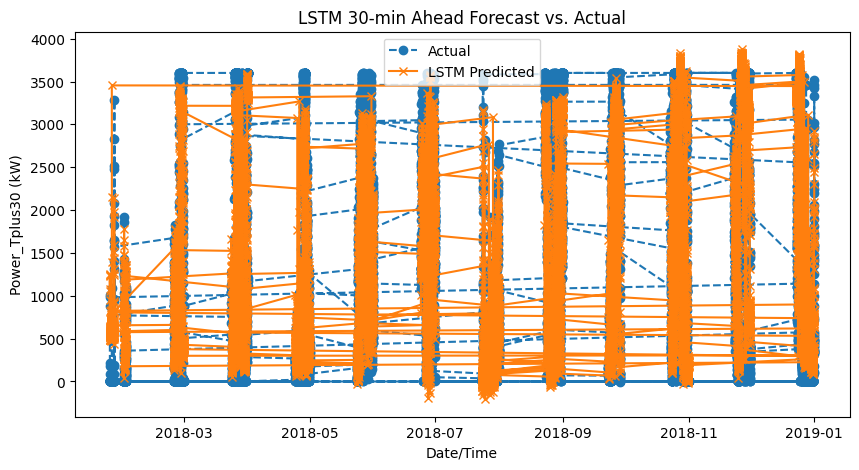

In [ ]:
target_scaler = MinMaxScaler()
# Fit the scaler on the training target and transform both training and test targets.
train_df['Power_Tplus30_scaled'] = target_scaler.fit_transform(train_df[['Power_Tplus30']])
test_df['Power_Tplus30_scaled']  = target_scaler.transform(test_df[['Power_Tplus30']])

# Define the input feature columns (engineered features, already scaled)
lstm_feature_cols = [
    'Wind Speed (m/s)', 'wd_sin', 'wd_cos',
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
    'Power_lag1', 'Power_lag2', 'Power_lag3',
    'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
    'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3'
]

# Extract input features as arrays from training and testing data
X_train_tab = train_df[lstm_feature_cols].values
X_test_tab  = test_df[lstm_feature_cols].values

# Extract the scaled target variable
y_train_tab = train_df['Power_Tplus30_scaled'].values
y_test_tab  = test_df['Power_Tplus30_scaled'].values

# Helper function: create sequences from tabular data.
def create_sequences(X, y, window_size=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# Choose a window size (e.g., 3 timesteps = 30 minutes if data is at 10-min intervals)
window_size = 3
X_train_seq, y_train_seq = create_sequences(X_train_tab, y_train_tab, window_size)
X_test_seq, y_test_seq   = create_sequences(X_test_tab, y_test_tab, window_size)

print("LSTM Training Sequence Shape:", X_train_seq.shape)
print("LSTM Test Sequence Shape:", X_test_seq.shape)


# Build and Tune the LSTM Model using KerasTuner
def build_lstm_model(hp):
    model = Sequential()
    # Hyperparameter: Number of LSTM units
    units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=units, activation='tanh', return_sequences=False,
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

    # Hyperparameter: Dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Output layer: predicting a single value (scaled Power_Tplus30)
    model.add(Dense(1))

    # Hyperparameter: Learning rate (log scale)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse')
    return model

# Initialize KerasTuner (RandomSearch)
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='wind_power_forecast'
)

tuner.search(X_train_seq, y_train_seq,
             epochs=20,
             batch_size=64,
             validation_split=0.2,
             shuffle=False,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
            )

# Retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best LSTM Hyperparameters:", best_hps.values)

# Build and train the best LSTM model
best_lstm_model = tuner.hypermodel.build(best_hps)

history_lstm = best_lstm_model.fit(X_train_seq, y_train_seq,
                                   epochs=20,
                                   batch_size=64,
                                   validation_split=0.2,
                                   shuffle=False,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
                                  )

# Evaluate the LSTM model on test sequences
lstm_preds_scaled = best_lstm_model.predict(X_test_seq)
# Invert the scaling to get predictions in original kW
lstm_preds = target_scaler.inverse_transform(lstm_preds_scaled)
y_test_original = target_scaler.inverse_transform(y_test_seq.reshape(-1,1))

lstm_rmse = np.sqrt(mean_squared_error(y_test_original, lstm_preds))
lstm_r2 = r2_score(y_test_original, lstm_preds)

print("LSTM Test RMSE (kW):", lstm_rmse)
print("LSTM Test R²:", lstm_r2)

# Optional: Plot Actual vs. LSTM Predictions
plt.figure(figsize=(10,5))
plt.plot(test_df['Date/Time'].iloc[window_size:], y_test_original, label='Actual', marker='o', linestyle='--')
plt.plot(test_df['Date/Time'].iloc[window_size:], lstm_preds, label='LSTM Predicted', marker='x', linestyle='-')
plt.xlabel('Date/Time')
plt.ylabel('Power_Tplus30 (kW)')
plt.title('LSTM 30-min Ahead Forecast vs. Actual')
plt.legend()
plt.show()

## **XGBoost Model Training & Hyperparameter Tuning**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

X_train_tab_final = train_df[lstm_feature_cols].values
y_train_tab_final = train_df['Power_Tplus30'].values

X_test_tab_final  = test_df[lstm_feature_cols].values
y_test_tab_final  = test_df['Power_Tplus30'].values

# Define the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define a broader hyperparameter space to search
param_distributions = {
    'n_estimators': [300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': list(range(3, 11)),  # 3 to 10
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 1],
    'min_child_weight': [1, 2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=100,  # try 30 random combinations
    scoring='neg_mean_squared_error',
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Starting XGBoost hyperparameter tuning...")
random_search.fit(X_train_tab_final, y_train_tab_final)

# Best parameters and score:
best_params_xgb = random_search.best_params_
print("Best XGBoost Hyperparameters:", best_params_xgb)

# Train final XGBoost model with best parameters on full training set.
final_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params_xgb)
final_xgb.fit(X_train_tab_final, y_train_tab_final)


# Evaluate on test set
xgb_preds = final_xgb.predict(X_test_tab_final)
xgb_rmse = np.sqrt(mean_squared_error(y_test_tab_final, xgb_preds))
xgb_r2   = r2_score(y_test_tab_final, xgb_preds)
print("XGBoost Test RMSE:", xgb_rmse)
print("XGBoost Test R²:", xgb_r2)


Starting XGBoost hyperparameter tuning...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGBoost Hyperparameters: {'subsample': 0.8, 'n_estimators': 700, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.6}
XGBoost Test RMSE: 472.15282472433154
XGBoost Test R²: 0.8718854932193301


In [ ]:

# Align lengths:
min_len = min(len(lstm_preds), len(xgb_preds))
lstm_preds = lstm_preds[:min_len]
xgb_preds   = xgb_preds[:min_len]
y_test_aligned = y_test_tab_final[:min_len]

# Use weighted average ensemble (you can tune the weight)
weight_lstm = 0.5
weight_xgb  = 0.5

ensemble_preds = weight_lstm * lstm_preds.flatten() + weight_xgb * xgb_preds

ensemble_rmse = np.sqrt(mean_squared_error(y_test_aligned, ensemble_preds))
ensemble_r2   = r2_score(y_test_aligned, ensemble_preds)

print("Ensemble Test RMSE:", ensemble_rmse)
print("Ensemble Test R²:", ensemble_r2)


Ensemble Test RMSE: 416.6433204812071
Ensemble Test R²: 0.9002423684751663


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure all arrays have the same length
min_len = min(len(lstm_preds), len(xgb_preds))
lstm_preds = lstm_preds[:min_len]
xgb_preds   = xgb_preds[:min_len]
y_test_aligned = y_test_aligned[:min_len]

best_rmse = np.inf
best_w_lstm, best_w_xgb = None, None

# Weight combinations from 0.0 to 1.0 (in 0.01 steps) for LSTM, and complementary for XGB
for w in np.linspace(0, 1, 101):
    ensemble_preds = w * lstm_preds.flatten() + (1 - w) * xgb_preds
    rmse = np.sqrt(mean_squared_error(y_test_aligned, ensemble_preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_w_lstm = w
        best_w_xgb = 1 - w
ensemble_r2   = r2_score(y_test_aligned, ensemble_preds)

print("Optimized Ensemble Weights:")
print(f"  LSTM weight: {best_w_lstm:.2f}, XGBoost weight: {best_w_xgb:.2f}")
print("Ensemble RMSE with optimized weights:", best_rmse)
print("Ensemble R² with optimized weights:", ensemble_r2)


Optimized Ensemble Weights:
  LSTM weight: 0.73, XGBoost weight: 0.27
Ensemble RMSE with optimized weights: 410.04963121226325
Ensemble R² with optimized weights: 0.8991167815127237


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=False)
n_meta = len(X_train_tab_final) - window_size

# Prepare arrays to hold meta features
meta_train_features = np.zeros((n_meta, 2))
meta_train_targets = np.zeros(n_meta)

fold_indices = np.arange(n_meta)

# Collect predictions from each fold.
for train_idx, val_idx in kf.split(X_train_tab_final):
    # For the fold, split the tabular training data.
    X_tr, X_val = X_train_tab_final[train_idx], X_train_tab_final[val_idx]
    y_tr, y_val = y_train_tab_final[train_idx], y_train_tab_final[val_idx]

    # Train an XGBoost model on this fold.
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params_xgb)
    model_xgb.fit(X_tr, y_tr)

    # For LSTM, generate sequences from X_val and y_val.
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, window_size)
    # Predict using the trained LSTM model on these sequences.
    preds_lstm = best_lstm_model.predict(X_val_seq).flatten()

    preds_xgb = model_xgb.predict(X_val[window_size:])

    # Ensure the lengths match.
    n_samples = len(y_val_seq)
    # Store these predictions into our meta-feature array.
    if 'meta_features_list' not in locals():
        meta_features_list = []
        meta_targets_list = []
    meta_features_list.append(np.column_stack((preds_lstm, preds_xgb)))
    meta_targets_list.append(y_val_seq)

# Concatenate all folds’ predictions.
meta_train_features = np.vstack(meta_features_list)
meta_train_targets = np.concatenate(meta_targets_list)

# Train a meta-learner (e.g. linear regression) on the meta-features.
meta_model = LinearRegression()
meta_model.fit(meta_train_features, meta_train_targets)


# For the test set, generate sequences for LSTM.
X_test_seq, y_test_seq = create_sequences(X_test_tab_final, y_test_tab_final, window_size)
# LSTM predictions on test sequences.
lstm_test_preds = best_lstm_model.predict(X_test_seq).flatten()
# XGBoost predictions on test set (align with sequences: discard first 'window_size' rows)
xgb_test_preds = final_xgb.predict(X_test_tab_final[window_size:])

# Combine into test meta-features.
test_meta_features = np.column_stack((lstm_test_preds, xgb_test_preds))

# Meta-learner predictions on test meta-features.
stacked_preds = meta_model.predict(test_meta_features)

# Evaluate the stacked ensemble.
stacked_rmse = np.sqrt(mean_squared_error(y_test_tab_final[window_size:], stacked_preds))
stacked_r2 = r2_score(y_test_tab_final[window_size:], stacked_preds)

print("Stacked Ensemble Test RMSE:", stacked_rmse)
print("Stacked Ensemble Test R²:", stacked_r2)


237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Stacked Ensemble Test RMSE: 471.6910458319378
Stacked Ensemble Test R²: 0.8721356644371827
